In [1]:
from functools import partial
import os
import torch
from guided_diffusion.unet import create_model
from guided_diffusion.gaussian_diffusion import create_sampler
from util.logger import get_logger
import numpy as np
from skimage.io import imsave
import warnings
warnings.filterwarnings('ignore')
from util.utils import image_read,load_yaml,norm_img,tensor_to_numpy
from guided_diffusion.unet import create_model,create_model_ir
import matplotlib.pyplot as plt

In [2]:
model_config = load_yaml('configs/vi_model_config_imagenet.yaml')  
ir_model_config = load_yaml('configs/ir_model_config_imagenet.yaml') 
diffusion_config = load_yaml('configs/diffusion_config.yaml')

logger = get_logger()
device = "cuda:1"
mode = 'RGB' #RGB:[1,1,H,W,3] GRAY:[1,1,H,W]
input_path="./input"     
out_path = f'./output2/{diffusion_config["sampler"]}'

# Working directory
os.makedirs(out_path, exist_ok=True)
os.makedirs(os.path.join(out_path, 'recon'), exist_ok=True)
os.makedirs(os.path.join(out_path, 'progress'), exist_ok=True)

img_name = "FLIR_08248.jpg"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


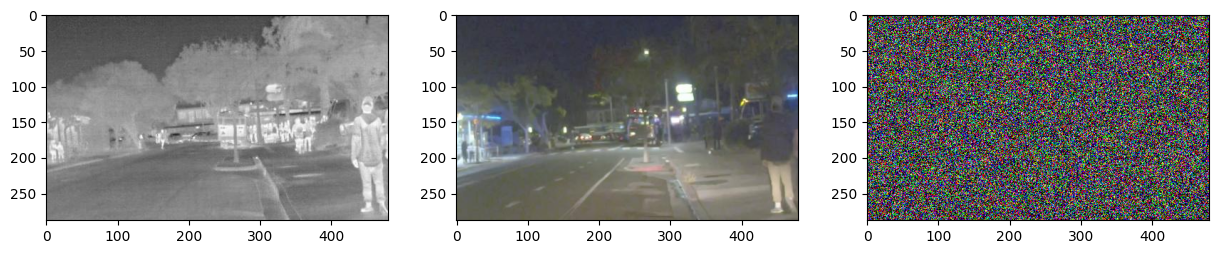

In [3]:
ir_img = image_read(os.path.join(os.path.join(input_path,"ir"), img_name),mode=mode)[np.newaxis,np.newaxis, ...]/255.0 
vi_img = image_read(os.path.join(os.path.join(input_path,"vi"),img_name), mode=mode)[np.newaxis,np.newaxis, ...]/255.0 
if mode == "RGB":
    #  (B, H, W, C)
    ir_img = np.squeeze(ir_img, axis=1)  
    vi_img = np.squeeze(vi_img, axis=1) 
    #  (B, C, H, W)
    ir_img = np.transpose(ir_img, (0, 3, 1, 2))  
    vi_img = np.transpose(vi_img, (0, 3, 1, 2)) 

# crop to make divisible
scale = 32
h, w = ir_img.shape[2:]
h = h - h % scale
w = w - w % scale

ir_img = ((torch.FloatTensor(ir_img))[:,:,:h,:w]).to(device)
vi_img = ((torch.FloatTensor(vi_img))[:,:,:h,:w]).to(device)

assert ir_img.shape == vi_img.shape

if mode == "RGB":# (1, 3, H, W)
    x_start = torch.randn(ir_img.shape, device=device)  
elif mode == "GRAY":# (1, 1, H, W)
    # x_start = torch.randn((ir_img.repeat(1, 3, 1, 1)).shape, device=device)  
    x_start = torch.randn_like(ir_img, device=device)

# Sampling
seed = 3407
torch.manual_seed(seed)


inf_np = tensor_to_numpy(ir_img.squeeze().permute(1, 2, 0))
vis_np = tensor_to_numpy(vi_img.squeeze().permute(1, 2, 0))
x_np = tensor_to_numpy(x_start.squeeze().permute(1, 2, 0))
# 创建子图
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# 显示原始RGB图像
axs[0].imshow(inf_np)
axs[1].imshow(vis_np)
axs[2].imshow(x_np)
# 显示图像
plt.show()

In [4]:
# Load model
model = create_model(**model_config)
model = model.to(device)
model.eval()
ir_model = create_model_ir(**ir_model_config)  
ir_model = ir_model.to(device)
ir_model.eval()

# 根据 diffusion_config.sampler 参数来选择sampler
sampler = create_sampler(**diffusion_config) 
sample_fn = partial(sampler.p_sample_loop, model=model, ir_model = ir_model)

sampler = d3fm_mix


  0%|          | 0/100 [00:00<?, ?it/s]

d3fm 混合进行


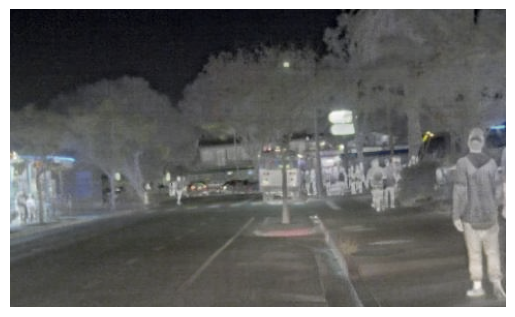

2024-08-04 22:03:14,610 [DPS] >> Save result in ./output2/d3fm_mix/recon


In [5]:
with torch.no_grad(): # rho=0.001
    sample = sample_fn(x_start=x_start, 
                        record=True, 
                        I = ir_img, 
                        V = vi_img, 
                        save_root=out_path, 
                        img_index = os.path.splitext(img_name)[0], 
                        lamb=0.5,
                        rho=0.001)
    
rgb_image = sample.squeeze().permute(1, 2, 0).cpu().numpy()
sample_norm=norm_img(rgb_image)
# 显示图像
plt.imshow(sample_norm)
plt.axis('off')  # 关闭坐标轴
plt.show()
save_path = os.path.join(out_path, 'recon')
save_name = "{}.png".format(img_name.split(".")[0])
imsave(os.path.join(save_path, save_name),sample_norm)
logger.info(f"Save result in {save_path}")